### Grading Feedback Cell
- **50**

<a href="https://colab.research.google.com/github/Sharvil-Turbadkar/Heath-Plan-Cross-Sell/blob/main/EnsembleModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install pyspark

if [[ ! -f ./train.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
fi

if [[ ! -f ./test.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/test.csv  
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=40ccf71ae65e68dac94f20692456fa891d8f4753279b197aeb67a805bc93e2d6
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-29 19:46:47--  https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21432357 (20M) [text/plain]
Saving to: ‘train.csv’

     0K .......... .......... .......... .......... ..........  0% 4.53M 5s
    50K .......... .......... .......... .......... ..........  0% 4.61M 4s
   100K .......... .......... .......... .......... ..........  0% 20.6M 3s
   150K .......... .......... .......... .......... ..........  0% 22.5M 3s
   200K .......... .......... .......... .......... ..........  1% 7.43M 3s
   250K .......... .......... .......... .......... ..........  1% 33.1M 2s
   300K .......... .......... .......... .......... ..........  1% 39.1M 2s
   350K ...

In [ ]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as fn

import random
import numpy as np
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

# **Pre-Processing**

In [ ]:
train = spark.read.csv('train.csv',inferSchema=True,header=True)
test=spark.read.csv('test.csv',inferSchema=True,header=True)

In [ ]:
train.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
test.toPandas().head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [ ]:
print(train.toPandas().shape, test.toPandas().shape)

(381109, 12) (127037, 11)


In [ ]:
# Check for null values
train.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in train.columns]).show()  

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+
|  0|     0|  0|              0|          0|                 0|          0|             0|             0|                   0|      0|       0|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+



In [ ]:
numerical_columns=['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
categorical_columns=['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Response']

In [ ]:
train.groupBy([col for col in categorical_columns]).count().show()

+------+---------------+------------------+-----------+--------------+--------+-----+
|Gender|Driving_License|Previously_Insured|Vehicle_Age|Vehicle_Damage|Response|count|
+------+---------------+------------------+-----------+--------------+--------+-----+
|  Male|              1|                 0|   < 1 Year|            No|       1|  172|
|  Male|              1|                 0|  > 2 Years|            No|       0|    4|
|Female|              1|                 1|   < 1 Year|           Yes|       0| 2122|
|  Male|              1|                 0|   1-2 Year|            No|       0| 7277|
|Female|              1|                 0|  > 2 Years|           Yes|       0| 4145|
|  Male|              0|                 0|   1-2 Year|           Yes|       0|  317|
|Female|              1|                 1|   < 1 Year|            No|       1|   14|
|Female|              0|                 0|   < 1 Year|           Yes|       0|    1|
|Female|              0|                 0|  > 2 Years

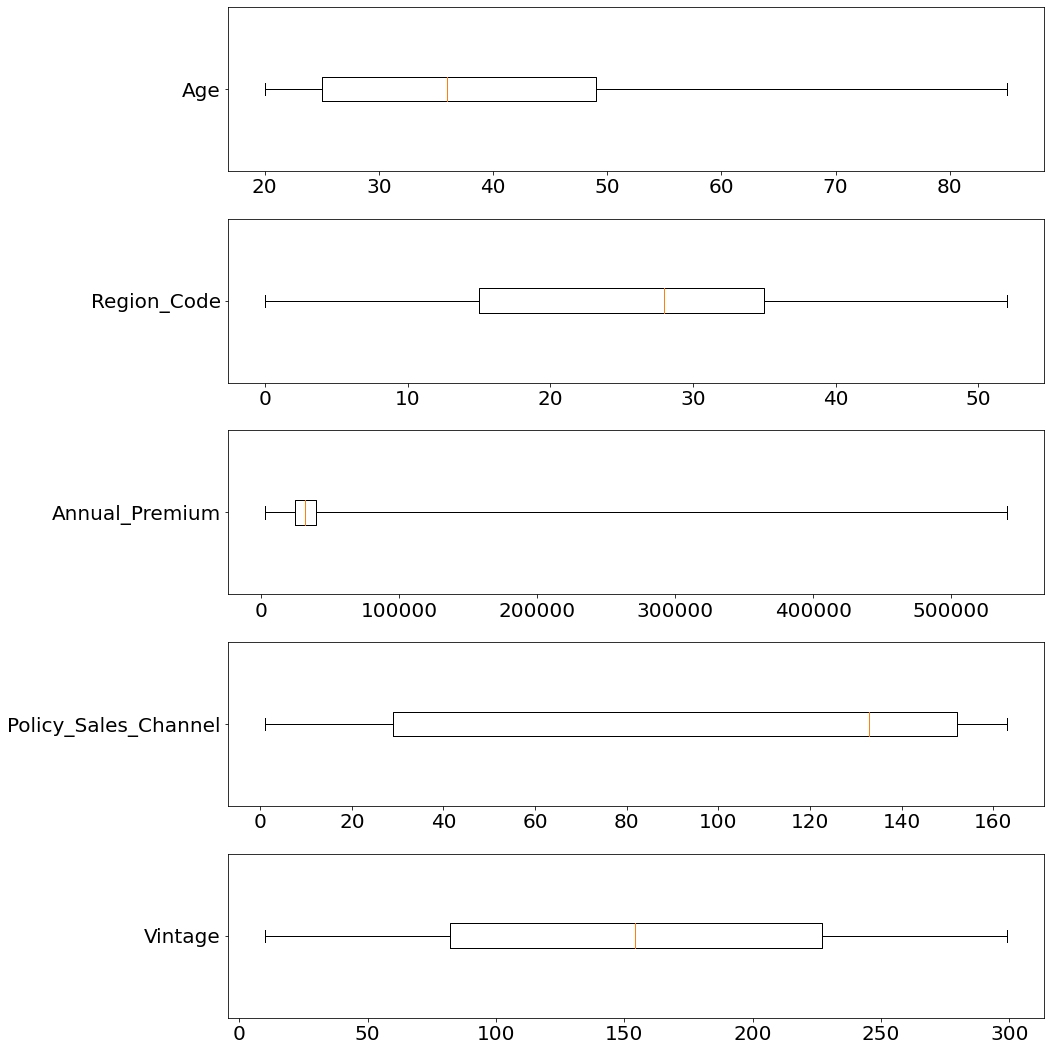

In [ ]:
from pyspark.sql import types as t
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.sql.types import DoubleType,IntegerType,StringType
from pyspark.sql.functions import  array
from pyspark.sql import Row,DataFrame
from functools import reduce
from pyspark.ml import Pipeline,Transformer
import pyspark.sql.functions as f

stats =list()
for col_name in numerical_columns:
  percentiles=train.select(col_name).agg(
      fn.expr(f'percentile({col_name},array(0))').alias('0%'),
      fn.expr(f'percentile({col_name},array(0.25))').alias('25%'),
      fn.expr(f'percentile({col_name},array(0.50))').alias('50%'),
      fn.expr(f'percentile({col_name},array(0.75))').alias('75%'),      
      fn.expr(f'percentile({col_name},array(1.00))').alias('100%')).toPandas()
  stats.append({'label': col_name,
                'med': percentiles.loc[0,'50%'],
                'q1': percentiles.loc[0,'25%'], 
                'q3':percentiles.loc[0,'75%'],
                'whislo':percentiles.loc[0,'0%'],
                'whishi':percentiles.loc[0,'100%']})
  
fig, ax = plt.subplots(len(numerical_columns), 1, sharex=False, figsize=(15,15))

for idx, s in enumerate(stats):
  ax[idx].bxp([stats[idx]], vert=False, showfliers=False);

plt.tight_layout()
display()           

In [ ]:
col=['Age','Annual_Premium','Policy_Sales_Channel','Vintage']

In [ ]:
#Pipeline
from pyspark.ml import  feature, Pipeline, regression, classification, evaluation, tuning
import math

feature_engineering_pipe=Pipeline(stages=[feature.StringIndexerModel().from_labels(['Male', 'Female'],
                                                          inputCol='Gender',outputCol='Gender_Feature'),
                 feature.StringIndexerModel().from_labels(['< 1 Year','> 2 Years','1-2 Year'],
                                                          inputCol='Vehicle_Age',outputCol='Vehicle_Age_feature'),
                 feature.StringIndexerModel().from_labels(['No','Yes'],inputCol='Vehicle_Damage',outputCol='Vehicle_Damage_Feature')])
train_xformed = feature_engineering_pipe.fit(train).transform(train).select(numerical_columns + 
                                                                            ['Driving_License', 'Previously_Insured', 'Response', 
                                                                             fn.col('Gender_Feature').alias('Gender'), 
                                                                             fn.col('Vehicle_Age_Feature').alias('Vehicle_Age'), 
                                                                             fn.col('Vehicle_Damage_Feature').alias('Vehicle_Damage')])

In [ ]:
# Applying log transform on skewed data as measurements are different across all dimensions
cols=train_xformed.columns
cols
log_imputer=fn.udf(lambda x:math.log(x+1),DoubleType())

df_xformed=train_xformed.withColumn("Age",log_imputer("Age"))\
                .withColumn("Region_Code",log_imputer("Region_Code"))\
                .withColumn("Annual_Premium",log_imputer("Annual_Premium"))\
                .withColumn("Policy_Sales_Channel",log_imputer("Policy_Sales_Channel"))\
                .withColumn("Vintage",log_imputer("Vintage"))
                

In [ ]:
print('After Log transformation:',df_xformed.show())

+------------------+------------------+------------------+--------------------+------------------+---------------+------------------+--------+------+-----------+--------------+
|               Age|       Region_Code|    Annual_Premium|Policy_Sales_Channel|           Vintage|Driving_License|Previously_Insured|Response|Gender|Vehicle_Age|Vehicle_Damage|
+------------------+------------------+------------------+--------------------+------------------+---------------+------------------+--------+------+-----------+--------------+
|3.8066624897703196| 3.367295829986474| 10.60794552424194|   3.295836866004329| 5.384495062789089|              1|                 0|       1|   0.0|        1.0|           1.0|
| 4.343805421853684|1.3862943611198906|10.420404585938435|   3.295836866004329| 5.214935757608986|              1|                 0|       0|   0.0|        2.0|           0.0|
| 3.871201010907891| 3.367295829986474|10.553074618343693|   3.295836866004329| 3.332204510175204|              1| 

In [ ]:
# Winsorizing the values to remove outliers
from pyspark.sql import DataFrameStatFunctions as statFunc
cols=['Age','Annual_Premium','Policy_Sales_Channel','Vintage']
def winsorize(df):
  def _winsorize(winlow,winhigh):
    def compare(value):
      if (value<winlow):
        return float(winlow)
      if (value>winhigh):
        return float(winhigh)
      return float(value)
    return compare  
  check=lambda col,winlow,winhigh :fn.udf(_winsorize(winlow,winhigh))(col)

  for col in cols:
    win_val= statFunc(df).approxQuantile(col,[0.05,0.95],0)
    winlow=win_val[0]
    winhigh=win_val[1]
    res=df.withColumn(col,check(col,winlow,winhigh).cast(DoubleType()))
  return res

__winsorize=winsorize(df_xformed)


**There are no otuliers .However columns like Age and Annual are rightly skewed** 


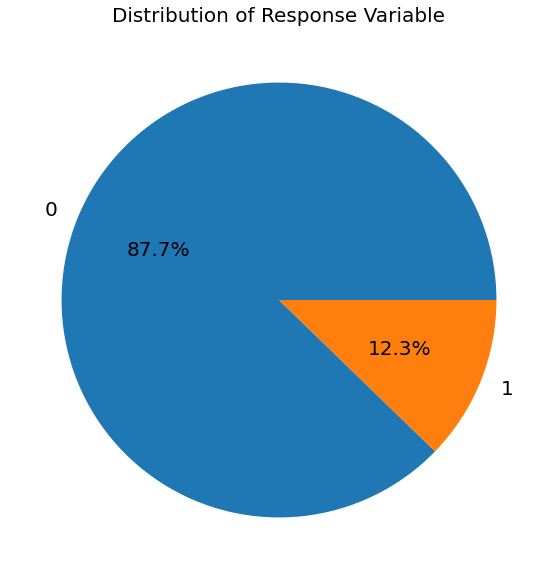

In [ ]:
# Before Oversampling
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20.0
data=__winsorize.select('Response').toPandas()
data=data.groupby('Response')['Response'].count()
labels=data.keys()
plt.figure(figsize=(10,10))
plt.pie(x=data,autopct="%.1f%%",labels=labels);
plt.title("Distribution of Response Variable",fontsize=20)
plt.show()

In [ ]:
# Oversampling
from pyspark.sql.functions import col, explode, array, lit

resp0=__winsorize.filter(__winsorize['Response']==0)
resp1=__winsorize.filter(__winsorize['Response']==1)

ratio=int(round(resp0.count()/resp1.count(),0))
print(ratio)
# Number of poeple not willing to buy the vehicle plan are 7.15 times larger than people willing to buy the vehicle plan
ratio=range(ratio)

# duplicate the minority rows
oversampled_df = resp1.withColumn("test",explode(array([lit(x) for x in ratio]))).drop('test')
# # combine both oversampled minority rows and previous majority rows
combined_df = resp0.unionAll(oversampled_df)
combined_df.show()

7
+------------------+------------------+------------------+--------------------+------------------+---------------+------------------+--------+------+-----------+--------------+
|               Age|       Region_Code|    Annual_Premium|Policy_Sales_Channel|           Vintage|Driving_License|Previously_Insured|Response|Gender|Vehicle_Age|Vehicle_Damage|
+------------------+------------------+------------------+--------------------+------------------+---------------+------------------+--------+------+-----------+--------------+
| 4.343805421853684|1.3862943611198906|10.420404585938435|   3.295836866004329| 5.214935757608986|              1|                 0|       0|   0.0|        2.0|           0.0|
| 3.091042453358316|2.4849066497880004|10.261861053110442|   5.030437921392435| 5.318119993844216|              1|                 1|       0|   0.0|        0.0|           0.0|
|3.4011973816621555|3.7376696182833684|10.221832186794726|   5.030437921392435|3.6888794541139363|              1

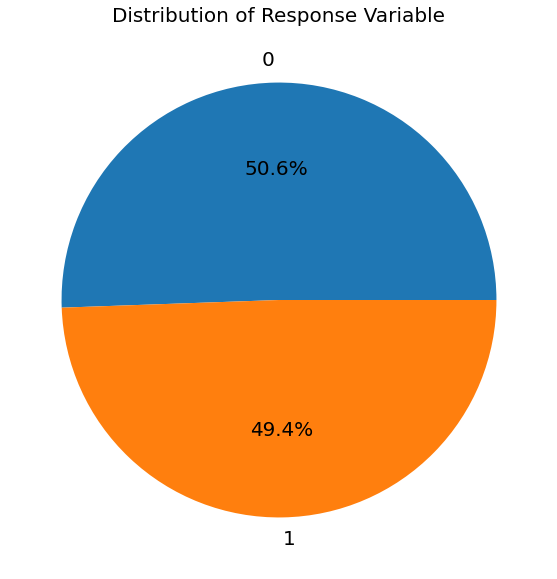

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20.0
data=combined_df.select('Response').toPandas()
data=data.groupby('Response')['Response'].count()
labels=data.keys()
plt.figure(figsize=(10,10))
plt.pie(x=data,autopct="%.1f%%",labels=labels);
plt.title("Distribution of Response Variable",fontsize=20)
plt.show()

# **Random Forest**

In [ ]:
# Performing train,validation test
train_df,validation_df=__winsorize.randomSplit([0.7,0.3],seed=12)
columns_to_drop = ['Response']
df=combined_df.drop(*columns_to_drop)
cols=df.columns
va=VectorAssembler(inputCols=cols,outputCol='features')
vi=VectorIndexer(maxCategories=8,inputCol='features',outputCol='indexedfeatures')
rf=RandomForestClassifier(labelCol='Response',featuresCol='indexedfeatures')
pipe=Pipeline(stages=[va,vi,rf])
paramGrid=ParamGridBuilder().addGrid(rf.numTrees,[25]).addGrid(rf.maxDepth,[20]).addGrid(rf.impurity,['entropy']).build()

eval=BinaryClassificationEvaluator(metricName='areaUnderPR',labelCol='Response')
# Using three fold cross validator
rfCrossValidator=CrossValidator(estimator=pipe,estimatorParamMaps=paramGrid,numFolds=3,evaluator=eval)
rfModel=rfCrossValidator.fit(combined_df)

In [ ]:
bestModel=rfModel.bestModel
print(f'Number of trees:{bestModel.stages[-1].getNumTrees}') 
print('Max Depth of tree : {}'.format(bestModel.stages[-1].getOrDefault('maxDepth')))
print('Best Impurity : {}'.format(bestModel.stages[-1].getOrDefault('impurity')))
print('Maximum number of Bins : {}'.format(bestModel.stages[-1].getOrDefault('maxBins')))

Number of trees:25
Max Depth of tree : 20
Best Impurity : entropy
Maximum number of Bins : 32


In [ ]:
rf_pred=bestModel.transform(validation_df)
print(f'PR AUC Metric {eval.evaluate(rf_pred)}')
rf_Accuracy=rf_pred.where('Response == prediction').count()/validation_df.count()
print('Accuracy {} '.format(rf_Accuracy))

PR AUC Metric 0.669633206613193
Accuracy 0.7830642481064913 


In [ ]:
import pandas as pd
importance=bestModel.stages[-1].featureImportances
feature=pd.DataFrame(importance.toArray(),columns=['weights'])
feature['feature']=pd.Series(cols)
feature=feature.sort_values(by=['weights'],ascending=False)

<Figure size 1440x1440 with 0 Axes>

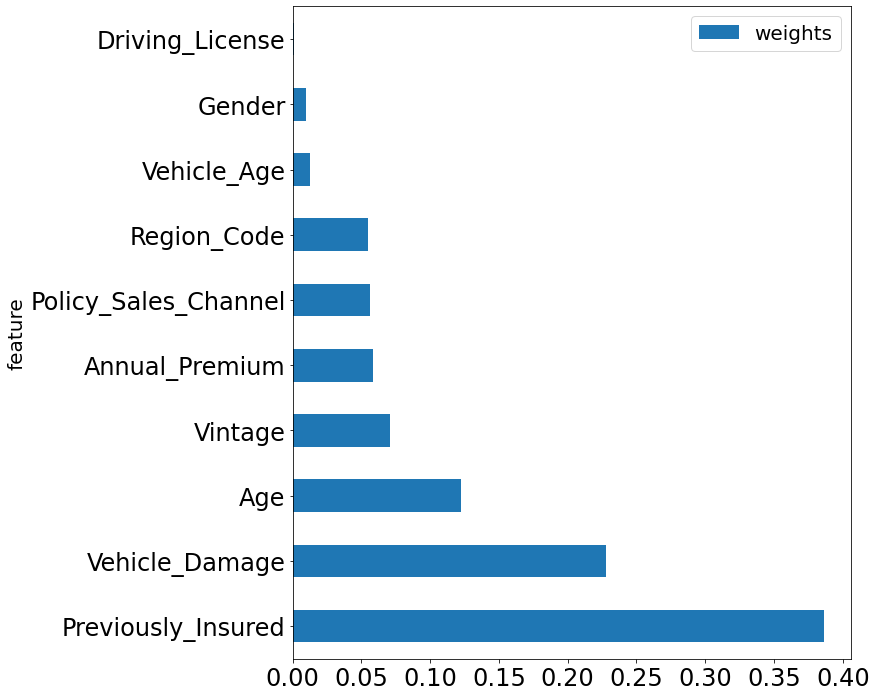

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
feature.plot.barh(x='feature',y='weights',figsize=(10,12),fontsize=24)

# **Gradient Boosting**

In [ ]:
# Performing train,validation test
from pyspark.ml.classification import GBTClassifier
train_df,validation_df=__winsorize.randomSplit([0.7,0.3],seed=12)
columns_to_drop = ['Response']
df=combined_df.drop(*columns_to_drop)
cols=df.columns
va=VectorAssembler(inputCols=cols,outputCol='features')
vi=VectorIndexer(inputCol='features',outputCol='indexedfeatures')
gbt=GBTClassifier(labelCol='Response',featuresCol='indexedfeatures')
pipe=Pipeline(stages=[va,vi,gbt])
paramGrid=ParamGridBuilder().addGrid(gbt.maxDepth,[10,16]).addGrid(gbt.maxIter,[10,15,20]).build()

eval=BinaryClassificationEvaluator(metricName='areaUnderPR',labelCol='Response')
# Using three fold cross validator
gbtCrossValidator=CrossValidator(estimator=pipe,estimatorParamMaps=paramGrid,numFolds=3,evaluator=eval)
gbtModel=gbtCrossValidator.fit(combined_df)

In [ ]:
bestModel2=gbtModel.bestModel
print('Max Depth of tree {}'.format(bestModel2.stages[-1].getOrDefault('maxDepth')))
print('Best Impurity : {}'.format(bestModel2.stages[-1].getOrDefault('impurity')))
print('Maximum number of iterations {}'.format(bestModel2.stages[-1].getOrDefault('maxIter')))

Max Depth of tree 16
Best Impurity : variance
Maximum number of iterations 20


In [ ]:
gb_pred=bestModel2.transform(validation_df)
print(f'PR AUC Metric : {eval.evaluate(gb_pred)}')
gb_accuracy=gb_pred.where('Response==prediction').count()/validation_df.count()
print(f'Accuracy : {gb_accuracy}')

PR AUC Metric : 0.6156056831037799
Accuracy : 0.7794084206475538


In [ ]:
import pandas as pd
importance=bestModel2.stages[-1].featureImportances
feature_gbt=pd.DataFrame(importance.toArray(),columns=['weights'])
feature_gbt['feature']=pd.Series(cols)

feature_gbt=feature_gbt.sort_values(by=['weights'],ascending=False)


<Figure size 1440x1440 with 0 Axes>

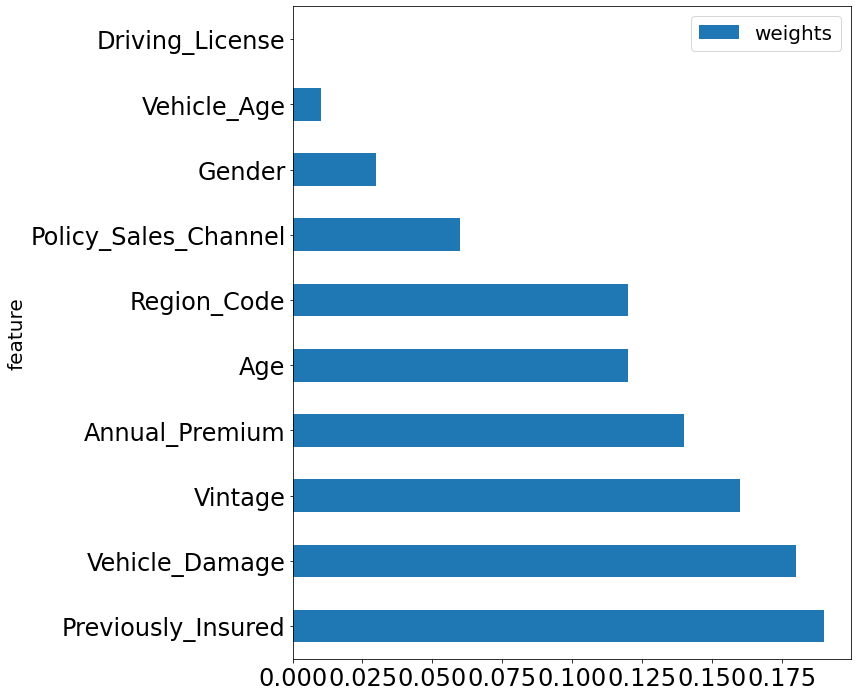

In [ ]:
plt.figure(figsize=(20,20))
feature_gbt.plot.barh(x='feature',y='weights',figsize=(10,12),fontsize=24)

# **Decision Tree**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
columns_to_drop = ['Response']
df=combined_df.drop(*columns_to_drop)
cols=df.columns
va=VectorAssembler(inputCols=cols,outputCol='features')
vi=VectorIndexer(inputCol='features',outputCol='indexedfeatures')
dt=DecisionTreeClassifier(labelCol='Response',featuresCol='indexedfeatures')
pipe=Pipeline(stages=[va,vi,dt])
paramGrid=ParamGridBuilder().addGrid(dt.maxDepth,[10,15,20]).addGrid(dt.impurity,['gini','entropy']).build()

eval=BinaryClassificationEvaluator(metricName='areaUnderPR',labelCol='Response')
# Using three fold cross validator
dtCrossValidator=CrossValidator(estimator=pipe,estimatorParamMaps=paramGrid,numFolds=3,evaluator=eval)
dtModel=dtCrossValidator.fit(combined_df)

In [ ]:
bestModel3=dtModel.bestModel
print('Max Depth of tree {}'.format(bestModel3.stages[-1].getOrDefault('maxDepth')))
print('Best Impurity : {}'.format(bestModel3.stages[-1].getOrDefault('impurity')))

Max Depth of tree 20
Best Impurity : gini


In [ ]:
dt_pred=bestModel3.transform(validation_df)
print(f'PR AUC Metric : {eval.evaluate(dt_pred)}')
dt_accuracy=dt_pred.where('Response==prediction').count()/validation_df.count()
print(f'Accuracy : {dt_accuracy}')

PR AUC Metric : 0.7692817349722534
Accuracy : 0.8645799484617884


<Figure size 1440x1440 with 0 Axes>

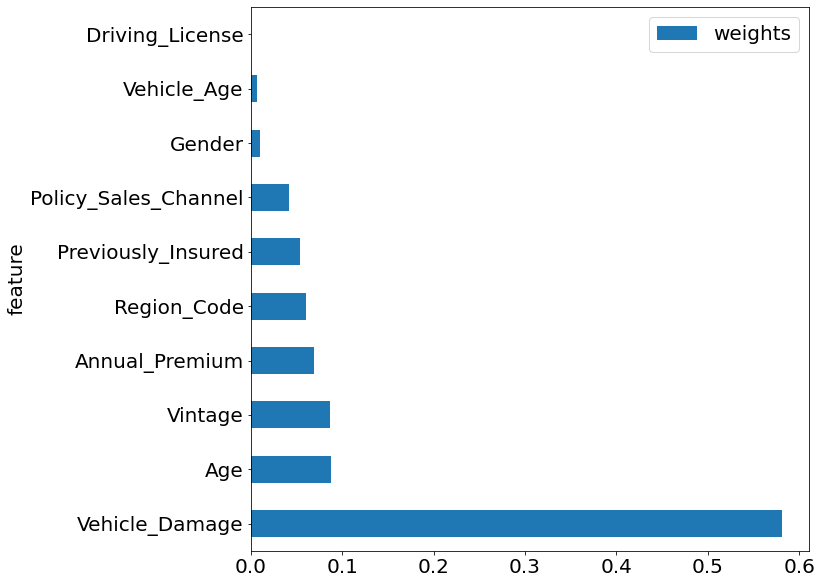

In [ ]:
import pandas as pd
importance=bestModel3.stages[-1].featureImportances
feature_dt=pd.DataFrame(importance.toArray(),columns=['weights'])
feature_dt['feature']=pd.Series(cols)
feature_dt=feature_dt.sort_values(by=['weights'],ascending=False)
plt.figure(figsize=(20,20))
feature_dt.plot.barh(x='feature',y='weights',figsize=(10,10),fontsize=20)